In [1]:
import os
import numpy as np
import nibabel as nib
import torch
import monai
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityRanged, Orientationd, ToTensord
from monai.networks.nets import UNet
import matplotlib.pyplot as plt

c:\Users\navee\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\navee\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\navee\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
DATASET_DIR = "./brats_dataset"

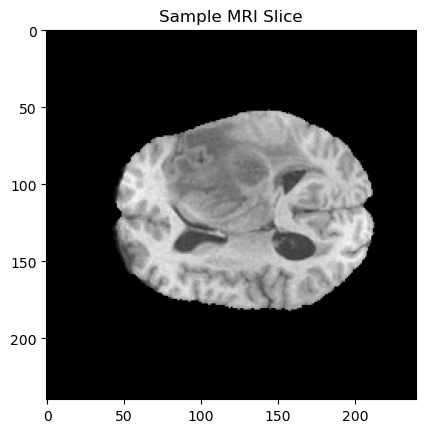

In [6]:
def load_mri_image(image_path):
    img = nib.load(image_path)
    img_data = img.get_fdata()
    return img_data

# Example usage
sample_image = load_mri_image(os.path.join(DATASET_DIR, "BraTS20_Training_001_t1.nii"))
plt.imshow(sample_image[:, :, sample_image.shape[2] // 2], cmap='gray')
plt.title("Sample MRI Slice")
plt.show()

In [ ]:
device = torch.device("cpu")
model = UNet(spatial_dims=3, in_channels=1, out_channels=3, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2))
model.to(device)
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): Inst

In [21]:
import os

data_path = "brats_dataset/"
nii_files = [f for f in os.listdir(data_path) if f.endswith(".nii.gz")]

print(f"Total .nii.gz files: {len(nii_files)}")
for file in nii_files[:5]:  # Show first 5 files
    print(file)

Total .nii.gz files: 5
BraTS20_Training_001.nii.gz
BraTS20_Training_001_0000.nii.gz
BraTS20_Training_001_0001.nii.gz
BraTS20_Training_001_0002.nii.gz
BraTS20_Training_001_0003.nii.gz


In [23]:
import os

data_path = "brats_dataset/"
files = os.listdir(data_path)
nii_files = [f for f in files if f.endswith(".nii") or f.endswith(".nii.gz")]

print("Found files:", nii_files)

Found files: ['BraTS20_Training_001.nii.gz', 'BraTS20_Training_001_0000.nii.gz', 'BraTS20_Training_001_0001.nii.gz', 'BraTS20_Training_001_0002.nii.gz', 'BraTS20_Training_001_0003.nii.gz']


In [27]:
# Step 1: Import Libraries
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, LoadImage, ToTensor, Resize

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [28]:
# Step 2: Define Dataset Class
class NiiDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        
        # Load .nii file using nibabel
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()  # Convert to numpy array
        
        # Normalize image to [0,1]
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data) + 1e-8)
        
        # Ensure correct shape (C, D, H, W) for PyTorch
        if len(img_data.shape) == 3:
            img_data = np.expand_dims(img_data, axis=0)  # (1, D, H, W)
    
        # Convert to PyTorch tensor
        img_tensor = torch.tensor(img_data, dtype=torch.float32)

        return img_tensor

In [29]:
# Load dataset
nii_folder = "brats_dataset"
ii_files = [os.path.join(nii_folder, f) for f in os.listdir(nii_folder) if f.endswith(".nii")]

if len(nii_files) == 0:
    raise RuntimeError("Dataset is empty! Check your file paths.")

In [30]:
# Step 3: Define DataLoader
dataset = NiiDataset(nii_files)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

In [31]:
# Debug: Check if the data is loading correctly
sample_batch = next(iter(dataloader))
print(f"Batch Shape: {sample_batch.shape}")  # Expected output: (4, 1, D, H, W)

# Possible Issue: Shape Mismatch in UNet
# Ensure that (D, H, W) are multiples of 16 for compatibility with U-Net

def pad_to_compatible_size(batch):
    _, _, d, h, w = batch.shape
    new_d = (d + 15) // 16 * 16
    new_h = (h + 15) // 16 * 16
    new_w = (w + 15) // 16 * 16
    pad_d = new_d - d
    pad_h = new_h - h
    pad_w = new_w - w
    
    batch = F.pad(batch, (0, pad_w, 0, pad_h, 0, pad_d), mode='constant', value=0)
    return batch

sample_batch = pad_to_compatible_size(sample_batch)
print(f"Padded Batch Shape: {sample_batch.shape}")

Batch Shape: torch.Size([4, 1, 240, 240, 155])
Padded Batch Shape: torch.Size([4, 1, 240, 240, 160])


In [42]:
import nibabel as nib

file_path = "brats_dataset/BraTS20_Training_001_0001.nii"
img = nib.load(file_path)

print(f"Shape: {img.shape}")
print(f"Affine Matrix:\n{img.affine}")

Shape: (240, 240, 155)
Affine Matrix:
[[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


In [15]:
# Step 3: Define Data Preprocessing Transform
transform = Compose([
    ToTensor(),  # Convert NumPy array to PyTorch tensor
    Resize((64, 64, 64))  # Ensure dimensions are compatible with U-Net
])

In [34]:
class CustomUNet(nn.Module):
    def __init__(self):
        super(CustomUNet, self).__init__()
        self.model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

    def forward(self, x):
        return self.model(x)

In [35]:
# Initialize Model
model = CustomUNet().to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Loss: 0.8756
Epoch [2/10], Loss: 0.7971
Epoch [3/10], Loss: 0.7714
Epoch [4/10], Loss: 0.7576
Epoch [5/10], Loss: 0.7484
Epoch [6/10], Loss: 0.7398
Epoch [7/10], Loss: 0.7326
Epoch [8/10], Loss: 0.7273
Epoch [9/10], Loss: 0.7228
Epoch [10/10], Loss: 0.7187


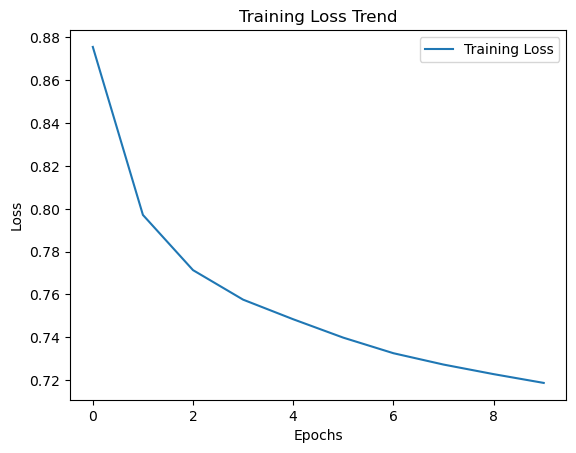

In [37]:
# Training Function
def train_model(model, dataloader, epochs=10, device=device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            if len(batch.shape) == 4:
                batch = batch.unsqueeze(1)
            batch = F.interpolate(batch, size=(64, 64, 64), mode="trilinear", align_corners=False)
            outputs = model(batch)
            targets = torch.zeros_like(outputs, device=device)
            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(dataloader))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
    return loss_history

# Train and Analyze
loss_history = train_model(model, dataloader, epochs=10)
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Trend')
plt.legend()
plt.show()

In [40]:
def segment_brain(image):
    """Run segmentation on a single image."""
    image = torch.tensor(image).unsqueeze(0).float()  # Add batch dim only
    image = image.to(device)

    # Ensure the image has the correct shape (Batch, Channel, Depth, Height, Width)
    if image.ndim == 4:  # (Batch, Depth, Height, Width)
        image = image.unsqueeze(1)  # Add Channel dim → (Batch, Channel, Depth, Height, Width)

    # Get dimensions
    _, _, d, h, w = image.shape  # Extract 5D shape properly

    # Resize input to nearest multiple of 16
    new_d, new_h, new_w = (x - x % 16 for x in (d, h, w))
    image = F.interpolate(image, size=(new_d, new_h, new_w), mode="trilinear", align_corners=False)

    with torch.no_grad():
        output = model(image)

    return output.squeeze(0).cpu().numpy()

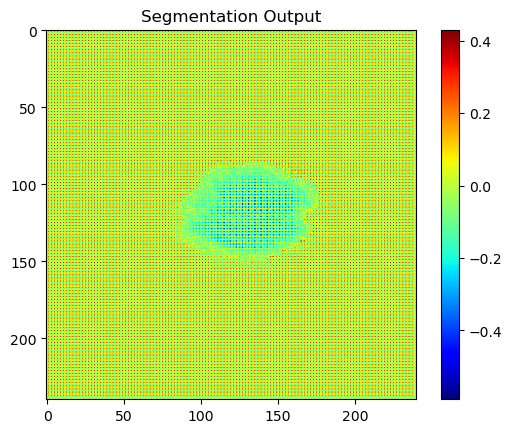

In [41]:
# Get a sample image from dataset
sample_image = dataset[0].numpy()  # Convert to NumPy
segmentation = segment_brain(sample_image)

# Visualize segmentation
plt.imshow(segmentation[0, :, :, segmentation.shape[2] // 2], cmap='jet')
plt.title("Segmentation Output")
plt.colorbar()
plt.show()

In [44]:
from scipy.stats import ttest_ind
import numpy as np

# Function to calculate the volume of segmented regions
def calculate_volume(segmented_image):
    return np.sum(segmented_image > 0)  # Count nonzero pixels

# Get the actual dataset size
dataset_size = len(dataset)  # Ensure dataset length is used
num_samples = min(10, dataset_size)  # Use the smaller value to prevent IndexError

if num_samples < 2:
    print("Not enough samples for statistical analysis.")
else:
    volumes_group1 = []
    volumes_group2 = []

    for i in range(num_samples):
        sample_image = dataset[i].numpy()  # Convert to NumPy
        segmentation = segment_brain(sample_image)  # Get segmentation output

        if i < num_samples // 2:
            volumes_group1.append(calculate_volume(segmentation))
        else:
            volumes_group2.append(calculate_volume(segmentation))

    # Ensure at least two samples in each group before running t-test
    if len(volumes_group1) > 1 and len(volumes_group2) > 1:
        t_stat, p_value = ttest_ind(volumes_group1, volumes_group2)
        print(f"T-Test Results: T-Statistic={t_stat:.4f}, P-Value={p_value:.4f}")
    else:
        print("Not enough samples in each group for statistical analysis.")

T-Test Results: T-Statistic=0.3206, P-Value=0.7789


T-Test Results: T-Statistic=0.3206, P-Value=0.7789


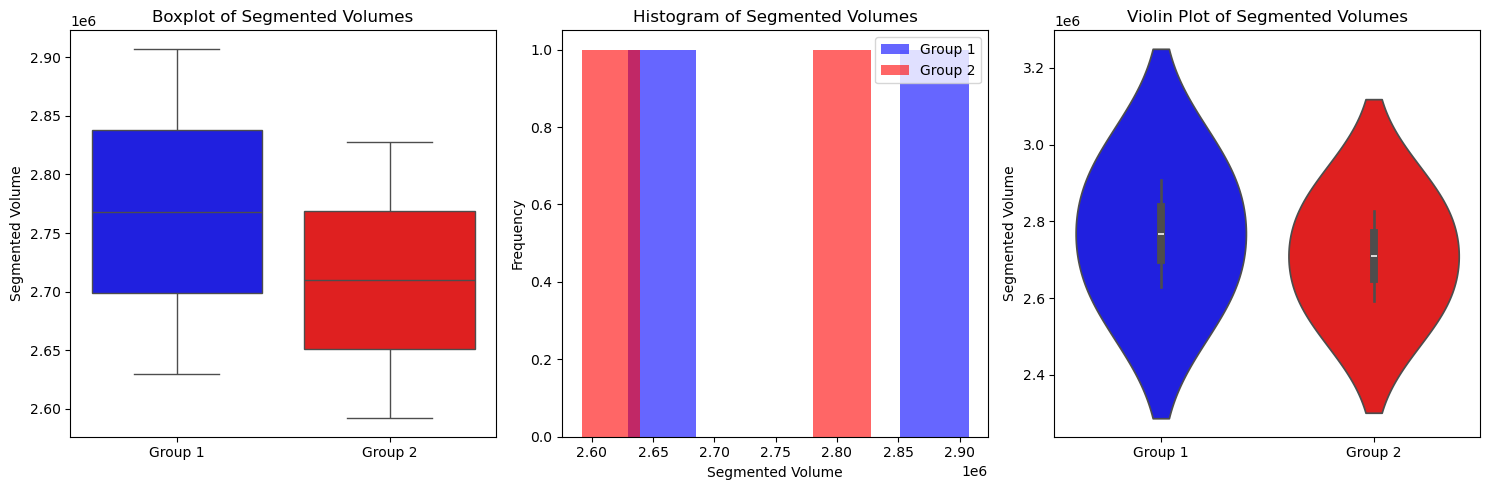

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Function to calculate the volume of segmented regions
def calculate_volume(segmented_image):
    return np.sum(segmented_image > 0)  # Count nonzero pixels

# Get the actual dataset size
dataset_size = len(dataset)
num_samples = min(10, dataset_size)  # Use the smaller value to prevent IndexError

if num_samples < 2:
    print("Not enough samples for statistical analysis.")
else:
    volumes_group1 = []
    volumes_group2 = []

    for i in range(num_samples):
        sample_image = dataset[i].numpy()  # Convert to NumPy
        segmentation = segment_brain(sample_image)  # Get segmentation output

        if i < num_samples // 2:
            volumes_group1.append(calculate_volume(segmentation))
        else:
            volumes_group2.append(calculate_volume(segmentation))

    # Ensure at least two samples in each group before running t-test
    if len(volumes_group1) > 1 and len(volumes_group2) > 1:
        t_stat, p_value = ttest_ind(volumes_group1, volumes_group2)
        print(f"T-Test Results: T-Statistic={t_stat:.4f}, P-Value={p_value:.4f}")

        # 📊 **Plot Statistical Analysis**
        plt.figure(figsize=(15, 5))

        # **1️⃣ Boxplot**
        plt.subplot(1, 3, 1)
        sns.boxplot(data=[volumes_group1, volumes_group2], palette=["blue", "red"])
        plt.xticks([0, 1], ["Group 1", "Group 2"])
        plt.ylabel("Segmented Volume")
        plt.title("Boxplot of Segmented Volumes")

        # **2️⃣ Histogram**
        plt.subplot(1, 3, 2)
        plt.hist(volumes_group1, bins=5, alpha=0.6, color="blue", label="Group 1")
        plt.hist(volumes_group2, bins=5, alpha=0.6, color="red", label="Group 2")
        plt.xlabel("Segmented Volume")
        plt.ylabel("Frequency")
        plt.legend()
        plt.title("Histogram of Segmented Volumes")

        # **3️⃣ Violin Plot**
        plt.subplot(1, 3, 3)
        sns.violinplot(data=[volumes_group1, volumes_group2], palette=["blue", "red"])
        plt.xticks([0, 1], ["Group 1", "Group 2"])
        plt.ylabel("Segmented Volume")
        plt.title("Violin Plot of Segmented Volumes")

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough samples in each group for statistical analysis.")